In [7]:


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from captum.attr import IntegratedGradients

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [8]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch

# Path to EuroSAT RGB dataset (ImageFolder format)
dataset_path = r"D:\datasets\2750\2750"  # <-- change if needed

# Settings
img_size = 64
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# EuroSAT RGB mean & std (precomputed)
mean = [0.344, 0.380, 0.408]
std  = [0.176, 0.176, 0.177]

# Transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_val = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform_train)
num_classes = len(dataset.classes)

# Train/Val split
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])
val_ds.dataset.transform = transform_val  # ensure val set uses val transform

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# Info print
print(f"Classes: {dataset.classes}")
print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")


Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Train size: 21600, Val size: 5400
Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [9]:
# Load pretrained ResNet18
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer for EuroSAT's number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move to GPU if available
model = model.to(device)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
import torch.optim as optim

# Hyperparameters
learning_rate = 0.001
num_epochs = 30  # you can increase to 50+ for better accuracy

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler (optional but helps training)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [16]:
train_acc_list, val_acc_list = [], []
train_loss_list, val_loss_list = [], []

best_acc = 0.0
num_epochs = 15  # or however many you want

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc.item())

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
    val_loss_list.append(val_epoch_loss)
    val_acc_list.append(val_epoch_acc.item())

    # Save best model
    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

print(f"Training complete! Best Val Accuracy: {best_acc:.4f}")


Epoch 1/15 Train Loss: 0.0006 Acc: 0.9998 | Val Loss: 0.1359 Acc: 0.9713
Epoch 2/15 Train Loss: 0.0006 Acc: 0.9999 | Val Loss: 0.1385 Acc: 0.9709
Epoch 3/15 Train Loss: 0.0009 Acc: 0.9999 | Val Loss: 0.1366 Acc: 0.9713
Epoch 4/15 Train Loss: 0.0005 Acc: 1.0000 | Val Loss: 0.1366 Acc: 0.9702
Epoch 5/15 Train Loss: 0.0010 Acc: 0.9997 | Val Loss: 0.1396 Acc: 0.9704
Epoch 6/15 Train Loss: 0.0005 Acc: 0.9999 | Val Loss: 0.1374 Acc: 0.9717
Epoch 7/15 Train Loss: 0.0006 Acc: 0.9999 | Val Loss: 0.1360 Acc: 0.9706
Epoch 8/15 Train Loss: 0.0011 Acc: 0.9997 | Val Loss: 0.1328 Acc: 0.9720
Epoch 9/15 Train Loss: 0.0004 Acc: 1.0000 | Val Loss: 0.1325 Acc: 0.9713
Epoch 10/15 Train Loss: 0.0006 Acc: 0.9999 | Val Loss: 0.1384 Acc: 0.9698
Epoch 11/15 Train Loss: 0.0009 Acc: 0.9997 | Val Loss: 0.1401 Acc: 0.9707
Epoch 12/15 Train Loss: 0.0006 Acc: 0.9998 | Val Loss: 0.1342 Acc: 0.9707
Epoch 13/15 Train Loss: 0.0007 Acc: 0.9997 | Val Loss: 0.1369 Acc: 0.9717
Epoch 14/15 Train Loss: 0.0006 Acc: 0.9999 | Va

In [17]:
# Save model
torch.save(model.state_dict(), "eurosat_resnet18.pth")

# Save training history
import pickle
history = {
    "train_acc": train_acc_list,
    "val_acc": val_acc_list,
    "train_loss": train_loss_list,
    "val_loss": val_loss_list
}
with open("eurosat_history.pkl", "wb") as f:
    pickle.dump(history, f)


In [2]:
# Plot training & validation curves
epochs_range = range(1, len(train_acc_list) + 1)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, val_acc_list, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label="Train Loss")
plt.plot(epochs_range, val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'train_acc_list' is not defined

In [2]:
import torch
import torchvision.models as models
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# Model path (should be .pth file, not an image)
model_path = r"C:\Users\Ekaansh\OneDrive\Desktop\AB\vs code\JS\projects\satelite\test 2\eurosat_resnet18.pth"


# Define class names
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 
               'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 
               'River', 'SeaLake']

# Parameters used during training
img_size = 64
mean = [0.3443, 0.3801, 0.4082]
std = [0.1909, 0.1511, 0.1475]

# Validation transform
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load and prepare image
img_path = r"D:\datasets\2750\2750\Residential\Residential_16.jpg"

 # Change to your test image path
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet18 and adjust for 10 classes (EuroSAT has 10 classes)
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)  # 10 classes

# Load weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Predict
input_tensor = input_tensor.to(device)
with torch.no_grad():
    outputs = model(input_tensor)
    probs = F.softmax(outputs, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()

print(f'Predicted class: {class_names[predicted_class]}')


C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_25628\192882880.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

Predicted class: Residential


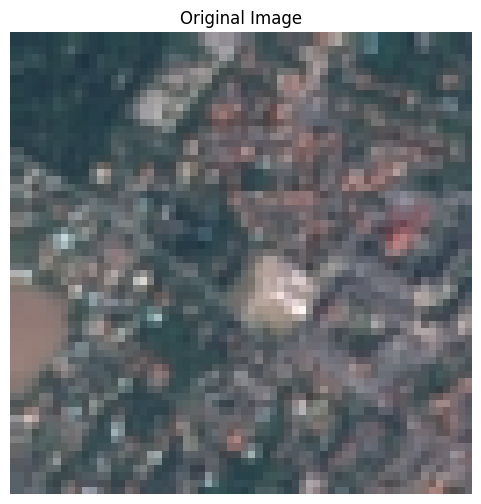

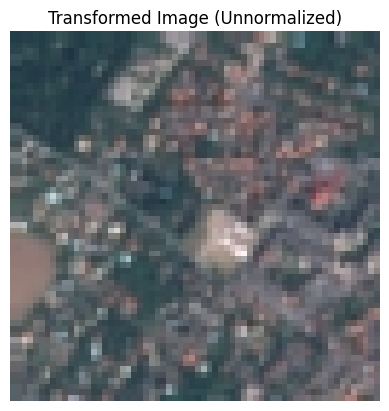

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Your image path (make sure to fix slashes as discussed)
img_path = r"D:\datasets\2750\2750\Residential\Residential_16.jpg"


# Load the original image
img = Image.open(img_path).convert('RGB')

# Show the original image
plt.figure(figsize=(6,6))
plt.title('Original Image')
plt.axis('off')
plt.imshow(img)
plt.show()

# Define the transform (validation transform you used)
img_size = 64
mean = [0.3443, 0.3801, 0.4082]
std = [0.1909, 0.1511, 0.1475]

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Apply transform
img_t = transform(img)

# To visualize the transformed image, we need to unnormalize it and convert to numpy
def imshow(tensor, mean, std):
    tensor = tensor.cpu().clone()  # clone tensor to not modify original
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # unnormalize
    np_img = tensor.numpy()
    np_img = np.transpose(np_img, (1, 2, 0))  # CHW to HWC
    plt.imshow(np_img)
    plt.axis('off')
    plt.title('Transformed Image (Unnormalized)')
    plt.show()

imshow(img_t, mean, std)


C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_25628\3307520423.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

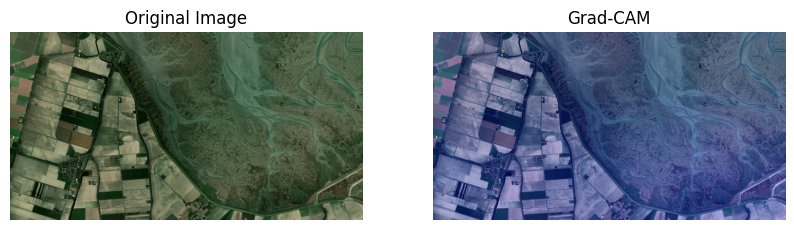

Predicted class: 2


In [6]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load your trained model (same as before)
model_path = r'C:\Users\Ekaansh\OneDrive\Desktop\AB\vs code\JS\projects\satelite\test 2\eurosat_resnet18.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)  # for EuroSAT 10 classes
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Transform for your input image
img_size = 64
mean = [0.3443, 0.3801, 0.4082]
std = [0.1909, 0.1511, 0.1475]

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load image
img_path = r'C:\Users\Ekaansh\Downloads\668ed88f4121ad584885a2a5_64da35f703a3998e7f2a50a0_image3-min.png'
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Hook for the feature maps and gradients
features = None
gradients = None

def forward_hook(module, input, output):
    global features
    features = output.detach()

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

# Register hooks to the last convolutional layer
last_conv_layer = model.layer4[-1].conv2
last_conv_layer.register_forward_hook(forward_hook)
last_conv_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Backward pass for the predicted class
model.zero_grad()
one_hot = torch.zeros_like(output)
one_hot[0][pred_class] = 1
output.backward(gradient=one_hot)

# Compute Grad-CAM heatmap
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
for i in range(features.shape[1]):
    features[0, i, :, :] *= pooled_gradients[i]

heatmap = features[0].mean(dim=0).cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= heatmap.max()

# Resize heatmap to original image size
heatmap = cv2.resize(heatmap, (img.width, img.height))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Overlay heatmap on image
img_np = np.array(img)
superimposed_img = heatmap * 0.4 + img_np

# Plot original and Grad-CAM overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.axis('off')
plt.imshow(superimposed_img.astype(np.uint8))

plt.show()

print(f'Predicted class: {pred_class}')
